In [ ]:
#let's outline the plan--> start writing down your diss so that you can actually code it out
"""
1. Clear dataset
2. Separate t into quarters
3. compute xiGK for all firms
-> compute sigkt for all products = one by one build up index
--> Use large language model to get product descriptions and compute matrix representation dot product
---> create a variable for xiGK for all quarters

#you will use these variables for the regressions

----> repeat this but get xikGt to construct a network

4.plot xiGK though time and see how it behaves --> do the same for the firm to supplier specific relationship network including all suppliers xikGt to visualise the network
5. Repeat across all firms and combine them into a single graph/regression for agregate results

SyntaxError: incomplete input (<ipython-input-1-73b755fc2324>, line 2)

**Part A: Creating Sikgt**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = '/content/drive/My Drive/DISS DATA/Tesla_BoL_Dataset.xlsx'
df = pd.read_excel(file_path)
print(df.head())

  Arrival Date Company Name                            Supplier Name  \
0   2024/09/28    Tesla Inc  Panasonic Operational Excellence Co Ltd   
1   2024/09/28    Tesla Inc                        Daehyun St Co Ltd   
2   2024/09/28    Tesla Inc  Panasonic Operational Excellence Co Ltd   
3   2024/09/28    Tesla Inc  Panasonic Operational Excellence Co Ltd   
4   2024/09/28    Tesla Inc                    Posco Future M Co Ltd   

          Product Description Destination Port Departure Port  \
0       Separator Film Pervio  Los Angeles, Ca          Pusan   
1  Single Sided Adhesive Tape  Los Angeles, Ca          Pusan   
2       Separator Film Pervio  Los Angeles, Ca          Pusan   
3                         NaN  Los Angeles, Ca          Pusan   
4                Anode Active  Los Angeles, Ca          Pusan   

    Supplier Country  TEU  Weight  Containers Count  ...  \
0  Republic Of Korea  3.0   15123                 2  ...   
1  Republic Of Korea  1.5    5565                 1  ...

In [4]:
# Convert "Arrival Date" to a proper datetime
df['Arrival Date'] = pd.to_datetime(df['Arrival Date'], errors='coerce')

# Drop any rows without a valid date
df = df.dropna(subset=['Arrival Date'])

In [5]:
print(df['Arrival Date'].dtypes)


datetime64[ns]


In [6]:
# ============================================================
# 2. IDENTIFY "TESLA BRAND" COMPANIES
# ============================================================
# Filter for ANY row where the Company Name contains 'tesla' (case-insensitive).
# This captures lines for "Tesla Inc.", "Everson Tesla Inc.", "Panasonic C/O Tesla Inc.", etc.
df_tesla = df[df['Company Name'].str.contains("tesla", case=False, na=False)]
#print(df_tesla['Company Name'])

In [7]:
df_tesla = df_tesla[df_tesla['Company Name'] != "Everson Tesla Inc"]

In [8]:
print(df_tesla['Company Name'].unique())

['Tesla Inc' 'Panasonic C/O Tesla Inc' 'Zeppelin Systems Co Tesla Inc'
 'M/S Tesla Inc' 'Xpo Logistics Wilmer C O Tesla Inc' 'Tesla Inc Branch'
 'Nano Tesla Inc' 'Cnee Tesla Inc' 'Panasonic C O Tesla Inc'
 'Consignee Tesla Inc' 'Bali Body Tesla Inc']


In [9]:
# ========== 2. DEFINE QUARTER COLUMN ==========
df['Quarter'] = df['Arrival Date'].dt.to_period('Q')

In [10]:
# ========== 3. SUM TOTAL VOLUME PER (QUARTER, HS CODE) ==========
# We'll call the columns "Quantity" or "Volume" depending on your dataset.
# Modify if you use "Weight" or something else.

group_total = (df
   .groupby(['Quarter', 'HS Code'], as_index=False)
   .agg(TotalVolume=('Quantity', 'sum'),FullDescription=('HS Code Full Description', 'first'))
)

In [11]:
print(group_total.head(500000))

     Quarter   HS Code  TotalVolume  \
0     2015Q1  731010.0          4.0   
1     2015Q1  740710.0          3.0   
2     2015Q1  850300.0         14.0   
3     2015Q2  740710.0         24.0   
4     2015Q2  850300.0          8.0   
...      ...       ...          ...   
2172  2024Q3  841581.0          8.0   
2173  2024Q3  850650.0         60.0   
2174  2024Q3  851030.0         13.0   
2175  2024Q3  853649.0         60.0   
2176  2024Q3  854311.0      55404.0   

                                        FullDescription  
0     Articles of iron or steel ; Tanks, casks, drum...  
1     Copper and articles thereof ; Copper bars, rod...  
2     Electrical machinery and equipment and parts t...  
3     Copper and articles thereof ; Copper bars, rod...  
4     Electrical machinery and equipment and parts t...  
...                                                 ...  
2172  Nuclear reactors, boilers, machinery and mecha...  
2173  Electrical machinery and equipment and parts t...  
2174  Ele

In [70]:
# Filter for rows where the Quarter is '2015Q1'
filtered_df = group_total[group_total['Quarter'] == '2016Q1']

# Group by HS Code and sum the Quantity column
hs_code_quantity = filtered_df.groupby('HS Code')['TotalVolume'].sum()

# Display the result
print(hs_code_quantity)

Series([], Name: TotalVolume, dtype: float64)


In [13]:
# ========== 4. SUPPLIER-LEVEL VOLUME PER (QUARTER, HS CODE, SUPPLIER) ==========
group_supplier = (df
   .groupby(['Quarter', 'HS Code', 'Supplier Name'], as_index=False)
   .agg(SupplierVolume=('Quantity', 'sum'))
)


In [14]:
print(group_supplier.head(2000))

     Quarter   HS Code                                    Supplier Name  \
0     2015Q1  731010.0                   Dissaco Nv As Agent For Iba Sa   
1     2015Q1  740710.0                                   Luvata Pori Oy   
2     2015Q1  850300.0                    Traktionssysteme Austria Gmbh   
3     2015Q1  850300.0                           Zako Turcin Spol S R O   
4     2015Q2  740710.0                                   Luvata Pori Oy   
...      ...       ...                                              ...   
1995  2023Q2  401693.0                      Changchun Elringklinger Ltd   
1996  2023Q2  401693.0         Connor Manufacturing Services Jb Sdn Bhd   
1997  2023Q2  401693.0                              Daesol Ausys Co Ltd   
1998  2023Q2  401695.0              Fong Chen Plastic Technology Ind Su   
1999  2023Q2  401695.0  Fong Chen Plastic Technology Ind Su Zhou Co Ltd   

      SupplierVolume  
0                4.0  
1                3.0  
2               12.0  
3      

In [15]:
# ========== 5. MERGE & COMPUTE s_{k}^g(t) ==========
merged = pd.merge(
    group_supplier,         # has SupplierVolume
    group_total,            # has TotalVolume
    on=['Quarter','HS Code'],
    how='left'
)

In [16]:
# s_{k}^g(t) = SupplierVolume / TotalVolume
merged['s_k^g(t)'] = merged['SupplierVolume'] / merged['TotalVolume']

In [17]:
print(merged[['Quarter', 'HS Code', 'Supplier Name', 's_k^g(t)']])
 #this is per product

     Quarter   HS Code                            Supplier Name  s_k^g(t)
0     2015Q1  731010.0           Dissaco Nv As Agent For Iba Sa  1.000000
1     2015Q1  740710.0                           Luvata Pori Oy  1.000000
2     2015Q1  850300.0            Traktionssysteme Austria Gmbh  0.857143
3     2015Q1  850300.0                   Zako Turcin Spol S R O  0.142857
4     2015Q2  740710.0                           Luvata Pori Oy  1.000000
...      ...       ...                                      ...       ...
5726  2024Q3  841581.0                 Metso Outotec Finland Oy  1.000000
5727  2024Q3  850650.0        Asahi Kasei E Materials Korea Inc  1.000000
5728  2024Q3  851030.0            Traktionssysteme Austria Gmbh  1.000000
5729  2024Q3  853649.0  Panasonic Operational Excellence Co Ltd  1.000000
5730  2024Q3  854311.0  Panasonic Operational Excellence Co Ltd  1.000000

[5731 rows x 4 columns]


In [18]:
"""
Now that i have sikg(t) where i=Tesla&subsidiaries, k=Supplier Name, g=HS code, t=Quarter you have to compute Wgg' to get the
weighted importance of each product --> meaning how unique each product supplier k ships to i is, times how much they offer. this yields
xigk(t) for each supplier k for each product they offer. to find the supplier specific substitutability across all products, you first compute xigk(t)
which is sikg(t)*Wgg' for all the products, and then you summ across all products for each supplier. Then you can plot a temporal network of the
substitutability of each supplier to Tesla(i) as it changes for each quarter. WE WILL PROCEEED BY CALUCATING Wgg' USING COSINE SIMILARITY OF HS CODE
DESCRIPTION EMBEDDINGS.

SyntaxError: incomplete input (<ipython-input-18-6d026915c8e6>, line 1)

**Part B: Creating wgg' for all products (917 unique HS codes)**

In [19]:
###########################
# 1) LOAD AND PREP DATA   #
###########################

# Assume your DataFrame is `df` with columns:
#   'HS Code' and 'HS code Full Description'
# First, get a unique list of (HS Code, Description).
df_codes = df[['HS Code','HS Code Full Description']].drop_duplicates(subset=['HS Code'])

# Build a dictionary: {HS_code: description_text}.
desc_dict = dict(zip(df_codes['HS Code'], df_codes['HS Code Full Description']))

In [20]:
print(len(desc_dict)) #this means there are 917 unique products imported by tesla HS code wise. Note all HS code descriptions correspond to the HS code and are not product specific

917


In [21]:
import torch
from transformers import AutoTokenizer, AutoModel

In [22]:
#1. Setting up the model. I am using BERT for now
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [23]:
model.eval()  # We only need inference

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [24]:
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    # outputs.last_hidden_state shape: [batch_size, seq_length, hidden_dim]
    # We take the [CLS] token at index 0 to represent the entire text
    cls_vec = outputs.last_hidden_state[:, 0, :]
    return cls_vec.squeeze(0)  # shape: [hidden_dim]


In [25]:
#this computes dot product and divides by L2 to get the cosine similarity e{-1,1} aka how similary two unique descriptions of hs codes are
def cosine_sim(vec1, vec2):
    dot_val = torch.dot(vec1, vec2)
    norm_val = vec1.norm(p=2) * vec2.norm(p=2)
    return (dot_val / norm_val).item()


In [26]:
hs_codes = list(desc_dict.keys())  # e.g. [370220.0, 590610.0, 853649.0, ...]
n = len(hs_codes)

# Precompute embeddings for each unique HS Code
embeddings = {}
for code in hs_codes:
    text = str(desc_dict[code])  # in case of NaNs
    embeddings[code] = get_bert_embedding(text)

# Create an n x n array for pairwise similarities
W = np.zeros((n, n), dtype=float)

for i in range(n):
    for j in range(n):
        if i == j:
            W[i,j] = 1.0
        else:
            v1 = embeddings[hs_codes[i]]
            v2 = embeddings[hs_codes[j]]
            W[i,j] = cosine_sim(v1, v2)


In [27]:
print(W[:10, :10])
#non-normalized

[[1.         0.84674609 0.85259837 0.78366131 0.7981109  0.78033501
  0.81795686 0.82383519 0.85810536 0.80357081]
 [0.84674609 1.         0.85494196 0.87860185 0.78940856 0.8299222
  0.85580146 0.88033849 0.87890923 0.8505398 ]
 [0.85259837 0.85494196 1.         0.81248319 0.85560161 0.81271142
  0.90073049 0.8249495  0.88585848 0.85857254]
 [0.78366131 0.87860185 0.81248319 1.         0.81634486 0.82181376
  0.84740216 0.80748838 0.85907197 0.86023384]
 [0.7981109  0.78940856 0.85560161 0.81634486 1.         0.79876292
  0.82879722 0.77252394 0.89340287 0.90415448]
 [0.78033501 0.8299222  0.81271142 0.82181376 0.79876292 1.
  0.80724978 0.79543078 0.84371543 0.82672977]
 [0.81795686 0.85580146 0.90073049 0.84740216 0.82879722 0.80724978
  1.         0.8034023  0.8670482  0.88264638]
 [0.82383519 0.88033849 0.8249495  0.80748838 0.77252394 0.79543078
  0.8034023  1.         0.85492331 0.80897641]
 [0.85810536 0.87890923 0.88585848 0.85907197 0.89340287 0.84371543
  0.8670482  0.854923

In [28]:
#normalization {0,1}
W_min, W_max = W.min(), W.max()
W_norm = (W - W_min)/(W_max - W_min)
#This is mix max normalization which is not good since the rows do not sum up to 1 as ALberto wanted

In [29]:
"""
# 1. Calculate row sums
row_sums = W.sum(axis=1, keepdims=True)
# shape of row_sums is (n, 1), one sum per row


# 2. Divide each row by its sum
W_row_norm = W / row_sums
# Now each row i sums to 1,
# i.e. sum_j W_row_norm[i,j] = 1

#print(W_row_norm.sum(axis=1, keepdims=True)[:10, :10])

SyntaxError: incomplete input (<ipython-input-29-9a3cc3bac0b1>, line 1)

In [30]:

# 3. Convert back to a DataFrame, if desired
similarity_df_row_norm = pd.DataFrame(
    W_norm,
    index=hs_codes,     # same row labels
    columns=hs_codes    # same column labels
)

# Quick check that each row sums to ~1
print(similarity_df_row_norm.sum(axis=1))

370220.0    702.486961
590610.0    735.462034
853649.0    749.583100
210210.0    718.187821
284190.0    706.416691
               ...    
950619.0    690.850595
860610.0    741.169834
841199.0    726.026108
902214.0    712.458744
860799.0    751.204881
Length: 917, dtype: float64


In [31]:
print(similarity_df_row_norm.head(917))

          370220.0  590610.0  853649.0  210210.0  284190.0  392690.0  \
370220.0  1.000000  0.819108  0.826016  0.744646  0.761702  0.740720   
590610.0  0.819108  1.000000  0.828782  0.856709  0.751430  0.799250   
853649.0  0.826016  0.828782  1.000000  0.778666  0.829561  0.778935   
210210.0  0.744646  0.856709  0.778666  1.000000  0.783224  0.789679   
284190.0  0.761702  0.751430  0.829561  0.783224  1.000000  0.762472   
...            ...       ...       ...       ...       ...       ...   
950619.0  0.746762  0.774190  0.813701  0.791916  0.729601  0.806947   
860610.0  0.796189  0.824315  0.875943  0.799429  0.825347  0.751655   
841199.0  0.763288  0.785430  0.871292  0.790060  0.827401  0.793948   
902214.0  0.819344  0.792645  0.875301  0.787589  0.791459  0.693920   
860799.0  0.811359  0.822227  0.897061  0.798128  0.845700  0.827346   

          841370.0  741022.0  380190.0  391231.0  ...  852320.0  901910.0  \
370220.0  0.785127  0.792065  0.832516  0.768146  ...  0.7

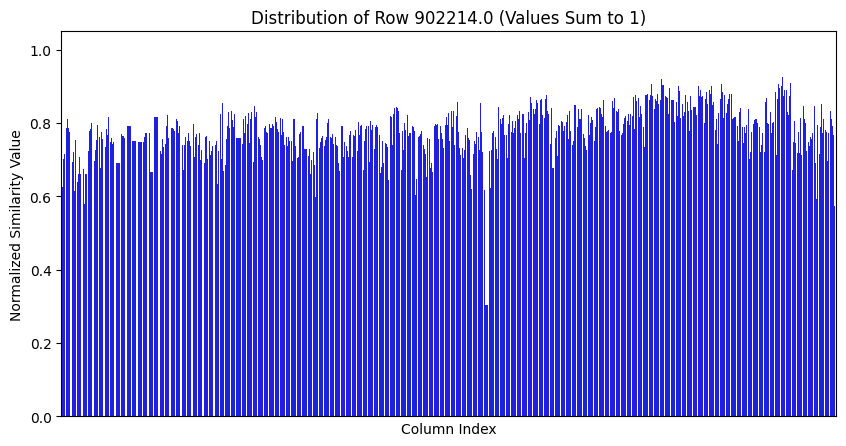

In [32]:

import matplotlib.pyplot as plt
import seaborn as sns

# Select a specific row (change index if needed)
row_index = 902214.0  # Example index from your dataset
row_values = similarity_df_row_norm.loc[row_index]

# Plot the distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=row_values.index, y=row_values.values, color="blue")

# Labels and title
plt.xlabel("Column Index")
plt.ylabel("Normalized Similarity Value")
plt.title(f"Distribution of Row {row_index} (Values Sum to 1)")
plt.xticks([])  # Remove x-ticks for readability

# Show plot
plt.show()


In [33]:
#this yields a large matrix nxn with all the similarities. I want the sum of wgg' for product g against all other products excluding g.

In [34]:
#Step 1: for each product g exctract wgg' -  this is the row for each product. (I am not sure how to know which product is assigned to which HS code in matrix form)

In [35]:
# 1) This function is applied row by row
#    "row" is a Series of length N, each element is w_{g, g'} for a single g but all columns g'.
#    row.name is the row label, i.e. the HS code of g itself.
#    We do row.drop(row.name) so we exclude w_{g,g} (the self-similarity on the diagonal).
#    Then we take the mean of the rest.
df_mean_sim = similarity_df_row_norm.apply(
    lambda row: row.drop(row.name).mean(),
    axis=1
)

# df_mean_sim is now a Series with index=HS code, and
# the value is the average similarity to all other codes.
print(df_mean_sim.head(10))


370220.0    0.765815
590610.0    0.801814
853649.0    0.817230
210210.0    0.782956
284190.0    0.770106
392690.0    0.758435
841370.0    0.811883
741022.0    0.770562
380190.0    0.816951
391231.0    0.806573
dtype: float64


In [36]:
#I am storing this in a new dataframe --> I have the aggregated similarity of each product with all other products | it's HS code. this is wgg' where g' is {geG|g=\G}
df_avg_similarity = pd.DataFrame({
    'HS Code': df_mean_sim.index,
    'MeanSimilarity': df_mean_sim.values
})
df_avg_similarity.reset_index(drop=True, inplace=True)
print(df_avg_similarity.head(917))


      HS Code  MeanSimilarity
0    370220.0        0.765815
1    590610.0        0.801814
2    853649.0        0.817230
3    210210.0        0.782956
4    284190.0        0.770106
..        ...             ...
912  950619.0        0.753112
913  860610.0        0.808046
914  841199.0        0.791513
915  902214.0        0.776702
916  860799.0        0.819001

[917 rows x 2 columns]


In [37]:
"""
I have succesfully created all wgg' for all g's (917 unique products HS code wise)
I am now going to compute xikgt across all quarters. where xigkt=sikt*wgg'and plot in a table to see. I can create temporal networks out of this computation.
"""


"\nI have succesfully created all wgg' for all g's (917 unique products HS code wise)\nI am now going to compute xikgt across all quarters. where xigkt=sikt*wgg'and plot in a table to see. I can create temporal networks out of this computation.\n"

**Part C: Computing Xikgt for all quarters and plotting a temporal network**

In [38]:
# 1) Merge on 'HS Code' to attach each product g's mean similarity
df_x = pd.merge(
    merged,                  # has s_k^g(t), Quarter, Supplier Name, ...
    df_avg_similarity,       # has 'HS Code' + 'MeanSimilarity'
    on='HS Code',            # matching column
    how='left'               # or 'inner' if you only want matching codes
)

print(df_x.head(10))


  Quarter   HS Code                   Supplier Name  SupplierVolume  \
0  2015Q1  731010.0  Dissaco Nv As Agent For Iba Sa             4.0   
1  2015Q1  740710.0                  Luvata Pori Oy             3.0   
2  2015Q1  850300.0   Traktionssysteme Austria Gmbh            12.0   
3  2015Q1  850300.0          Zako Turcin Spol S R O             2.0   
4  2015Q2  740710.0                  Luvata Pori Oy            24.0   
5  2015Q2  850300.0   Traktionssysteme Austria Gmbh             8.0   
6  2015Q2  871493.0       Tesla Engineering Limited             2.0   
7  2015Q3  740710.0                  Luvata Pori Oy            18.0   
8  2015Q3  850300.0          Zako Turcin Spol S R O             1.0   
9  2015Q4  740710.0                  Luvata Pori Oy             5.0   

   TotalVolume                                    FullDescription  s_k^g(t)  \
0          4.0  Articles of iron or steel ; Tanks, casks, drum...  1.000000   
1          3.0  Copper and articles thereof ; Copper bars, r

In [39]:
print(df_x.shape)


(5731, 8)


In [40]:
# 2) Multiply to get x_{ik}^g(t)
df_x['x_ik^g(t)'] = df_x['s_k^g(t)'] * df_x['MeanSimilarity']


In [41]:
# 3) Display the results
print(
    df_x[
      ['Quarter', 'HS Code', 'Supplier Name', 's_k^g(t)', 'MeanSimilarity', 'x_ik^g(t)']
    ].head(30000)
)


     Quarter   HS Code                            Supplier Name  s_k^g(t)  \
0     2015Q1  731010.0           Dissaco Nv As Agent For Iba Sa  1.000000   
1     2015Q1  740710.0                           Luvata Pori Oy  1.000000   
2     2015Q1  850300.0            Traktionssysteme Austria Gmbh  0.857143   
3     2015Q1  850300.0                   Zako Turcin Spol S R O  0.142857   
4     2015Q2  740710.0                           Luvata Pori Oy  1.000000   
...      ...       ...                                      ...       ...   
5726  2024Q3  841581.0                 Metso Outotec Finland Oy  1.000000   
5727  2024Q3  850650.0        Asahi Kasei E Materials Korea Inc  1.000000   
5728  2024Q3  851030.0            Traktionssysteme Austria Gmbh  1.000000   
5729  2024Q3  853649.0  Panasonic Operational Excellence Co Ltd  1.000000   
5730  2024Q3  854311.0  Panasonic Operational Excellence Co Ltd  1.000000   

      MeanSimilarity  x_ik^g(t)  
0           0.767992   0.767992  
1      

In [42]:
"""
I have computed x_ik^g(t) for each quarter. NOte wgg' is not time defined so we should include an assumption there. AKA we assume in the short run
firm i can replace suppliers from it's current set of suppliers easilly.
Now let's plot it as a network just for fun

SyntaxError: incomplete input (<ipython-input-42-b51421ae3e92>, line 1)

In [ ]:
#We first fing the relationship xik(t) by aggregating the substitutabilityu scores across all products of a supplier for a given quarter t.
"""
Code explanation:
What it does: For each (Quarter, Supplier Name) pair, it takes all rows of different HS codes and computes the mean of x_ik^g(t).
The resulting column 'Aggregated_x_ik' is your  in notation.

In [43]:
# 1) Group by quarter & supplier, then average x_{ik}^g(t) across products
df_x_agg = (
    df_x
    .groupby(['Quarter', 'Supplier Name'], as_index=False)
    .agg(Aggregated_x_ik=('x_ik^g(t)', 'mean'))  # or 'sum' if you prefer summation
)

# 2) Inspect the result
print(df_x_agg.head(15))

   Quarter                   Supplier Name  Aggregated_x_ik
0   2015Q1  Dissaco Nv As Agent For Iba Sa         0.767992
1   2015Q1                  Luvata Pori Oy         0.771778
2   2015Q1   Traktionssysteme Austria Gmbh         0.669096
3   2015Q1          Zako Turcin Spol S R O         0.111516
4   2015Q2                  Luvata Pori Oy         0.771778
5   2015Q2       Tesla Engineering Limited         0.809444
6   2015Q2   Traktionssysteme Austria Gmbh         0.780612
7   2015Q3                  Luvata Pori Oy         0.771778
8   2015Q3          Zako Turcin Spol S R O         0.780612
9   2015Q4                  Luvata Pori Oy         0.771778
10  2016Q2                  Luvata Pori Oy         0.771778
11  2016Q3                          Iba Sa         0.767992
12  2016Q3                  Luvata Pori Oy         0.771778
13  2016Q3   Traktionssysteme Austria Gmbh         0.780612
14  2016Q4                          Iba Sa         0.767992


In [44]:
#let's now visualise the network. the edges are the xik(t) for each quarter. suppliers keK are the nodes all of which ship to tesla

In [45]:
import networkx as nx

In [46]:
# 1) Filter by the quarter, then rename columns
quarter_of_interest = "2020Q3"
df_plot = df_x_agg[df_x_agg['Quarter'] == quarter_of_interest].copy()

print("Before rename, columns are:", df_plot.columns.tolist())
# Suppose we see "Supplier Name" and "Aggregated_x_ik" in that list.

df_plot.rename(
    columns={
        'Supplier Name': 'Supplier_Name',
        'Aggregated_x_ik': 'Aggregated_x_ik'
    },
    inplace=True
)
print("After rename, columns are:", df_plot.columns.tolist())

Before rename, columns are: ['Quarter', 'Supplier Name', 'Aggregated_x_ik']
After rename, columns are: ['Quarter', 'Supplier_Name', 'Aggregated_x_ik']


In [47]:
# 2) Use .itertuples() with named attributes
#    Now we can do row.Supplier_Name, row.Aggregated_x_ik, etc.
G = nx.Graph()
G.add_node("Tesla", bipartite=0)

for row in df_plot.itertuples(index=False):
    supplier = row.Supplier_Name  # now a valid attribute
    x_ik = row.Aggregated_x_ik

    G.add_node(supplier, bipartite=1)
    G.add_edge("Tesla", supplier, weight=x_ik)


In [48]:
# 3) Layout: Tesla on x=0, suppliers on x=2
pos = dict()
pos["Tesla"] = (0, 0)
for i, sup in enumerate(df_plot['Supplier_Name'].unique()):
    pos[sup] = (2, i*1.0)

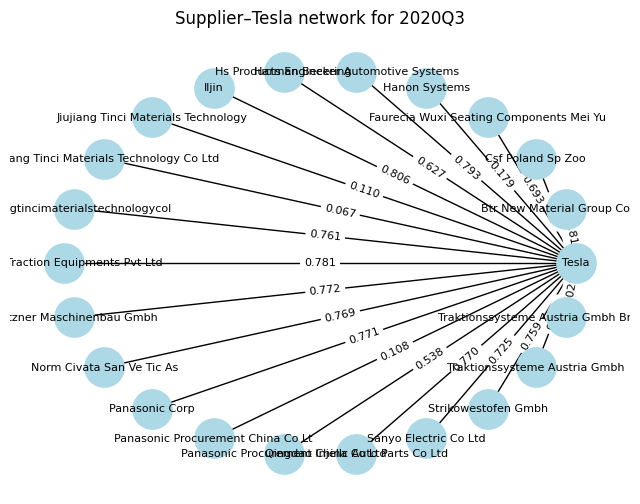

In [49]:
# 4) Draw
plt.figure(figsize=(8,6))
pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=800)
nx.draw_networkx_labels(G, pos, font_size=8)
nx.draw_networkx_edges(G, pos)

# Edge labels
edge_labels = {(u,v): f"{data['weight']:.3f}" for u,v,data in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title(f"Supplier–Tesla network for {quarter_of_interest}")
plt.axis("off")
plt.show()

In [50]:
"""
Cool now let's make it interactive

SyntaxError: incomplete input (<ipython-input-50-af834c1c72f0>, line 1)

In [51]:
import ipywidgets as widgets
from IPython.display import display


In [52]:
df_temp = df_x_agg.copy()

# Rename columns to simpler names so they work well with .itertuples()
df_temp.rename(
    columns={
        "Supplier Name": "Supplier_Name",
        "Aggregated_x_ik": "Aggregated_x_ik"
    },
    inplace=True
)

# Let's see the unique quarters
unique_quarters = sorted(df_temp['Quarter'].unique())
print("Available quarters:", unique_quarters)


Available quarters: [Period('2015Q1', 'Q-DEC'), Period('2015Q2', 'Q-DEC'), Period('2015Q3', 'Q-DEC'), Period('2015Q4', 'Q-DEC'), Period('2016Q2', 'Q-DEC'), Period('2016Q3', 'Q-DEC'), Period('2016Q4', 'Q-DEC'), Period('2017Q1', 'Q-DEC'), Period('2017Q2', 'Q-DEC'), Period('2017Q3', 'Q-DEC'), Period('2017Q4', 'Q-DEC'), Period('2018Q1', 'Q-DEC'), Period('2018Q2', 'Q-DEC'), Period('2018Q3', 'Q-DEC'), Period('2018Q4', 'Q-DEC'), Period('2019Q1', 'Q-DEC'), Period('2019Q2', 'Q-DEC'), Period('2019Q3', 'Q-DEC'), Period('2019Q4', 'Q-DEC'), Period('2020Q1', 'Q-DEC'), Period('2020Q2', 'Q-DEC'), Period('2020Q3', 'Q-DEC'), Period('2020Q4', 'Q-DEC'), Period('2021Q1', 'Q-DEC'), Period('2021Q2', 'Q-DEC'), Period('2021Q3', 'Q-DEC'), Period('2021Q4', 'Q-DEC'), Period('2022Q1', 'Q-DEC'), Period('2022Q2', 'Q-DEC'), Period('2022Q3', 'Q-DEC'), Period('2022Q4', 'Q-DEC'), Period('2023Q1', 'Q-DEC'), Period('2023Q2', 'Q-DEC'), Period('2023Q3', 'Q-DEC'), Period('2023Q4', 'Q-DEC'), Period('2024Q1', 'Q-DEC'), Period(

In [53]:
def plot_quarter_network(quarter_of_interest):
    """
    Given a quarter (string like '2015Q1'),
    build a bipartite (Tesla, Suppliers) network
    with edges weighted by Aggregated_x_ik.
    """
    # 1) Filter to the chosen quarter
    df_plot = df_temp[df_temp['Quarter'] == quarter_of_interest].copy()

    # 2) Create a graph; add Tesla as the single "buyer" node
    G = nx.Graph()
    G.add_node("Tesla", bipartite=0)

    # 3) Add edges from Tesla -> each supplier with 'weight' = x_ik
    for row in df_plot.itertuples(index=False):
        supplier = row.Supplier_Name
        x_ik = row.Aggregated_x_ik
        G.add_node(supplier, bipartite=1)
        G.add_edge("Tesla", supplier, weight=x_ik)

    # 4) Simple bipartite layout: Tesla on left, suppliers on right
    pos = {}
    pos["Tesla"] = (0, 0)
    for i, sup in enumerate(df_plot['Supplier_Name'].unique()):
        pos[sup] = (2, i * 1.0)  # x=2, different y

    # 5) Draw the network
    plt.figure(figsize=(8,6))
    pos = nx.circular_layout(G)
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=800)
    nx.draw_networkx_labels(G, pos, font_size=8)
    nx.draw_networkx_edges(G, pos)

    # 6) Edge labels for the x_ik weight
    edge_labels = {(u,v): f"{data['weight']:.3f}" for u,v,data in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title(f"Supplier–Tesla network for {quarter_of_interest}")
    plt.axis("off")
    plt.show()


In [54]:
# Create a dropdown widget to pick the quarter
quarter_dropdown = widgets.Dropdown(
    options=unique_quarters,
    description='Quarter:',
    value=unique_quarters[0]  # default selection
)

# Use `interact` to tie the function to the widget
widgets.interact(plot_quarter_network, quarter_of_interest=quarter_dropdown)


interactive(children=(Dropdown(description='Quarter:', options=(Period('2015Q1', 'Q-DEC'), Period('2015Q2', 'Q…

<function __main__.plot_quarter_network(quarter_of_interest)>

In [55]:
"""
Next steps - find controll data & regression data & start regressing for tesla

SyntaxError: incomplete input (<ipython-input-55-b12e34f396e5>, line 1)

In [56]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [57]:
#!!!!!!!!!Weight by transaction amount - update: Sikgt is already a weight by transaction amount so no need to weight

In [58]:
###############################################
# A) AGGREGATE X_ik(t) INTO X(t) PER QUARTER #
###############################################

# Suppose your DataFrame "df_x_agg" has columns:
#  ['Quarter', 'Supplier Name', 'Aggregated_x_ik']
#  from the step where you group by (Quarter, Supplier)
#  and average x_{ik}^g(t) across products.

# 1) For each Quarter, average across all suppliers:
df_quarter_x = (
    df_x_agg
    .groupby('Quarter', as_index=False)
    .agg(Xit=('Aggregated_x_ik', 'mean'))  # call it "X" for x(t)
)

print(df_quarter_x.head(40))

   Quarter       Xit
0   2015Q1  0.580095
1   2015Q2  0.787278
2   2015Q3  0.776195
3   2015Q4  0.771778
4   2016Q2  0.771778
5   2016Q3  0.773461
6   2016Q4  0.787569
7   2017Q1  0.766145
8   2017Q2  0.665114
9   2017Q3  0.621730
10  2017Q4  0.763491
11  2018Q1  0.777181
12  2018Q2  0.768006
13  2018Q3  0.740182
14  2018Q4  0.697946
15  2019Q1  0.762491
16  2019Q2  0.796779
17  2019Q3  0.783981
18  2019Q4  0.623179
19  2020Q1  0.643052
20  2020Q2  0.782919
21  2020Q3  0.591512
22  2020Q4  0.657301
23  2021Q1  0.790424
24  2021Q2  0.725389
25  2021Q3  0.788953
26  2021Q4  0.718089
27  2022Q1  0.645575
28  2022Q2  0.626115
29  2022Q3  0.684257
30  2022Q4  0.645599
31  2023Q1  0.275529
32  2023Q2  0.226382
33  2023Q3  0.238799
34  2023Q4  0.544158
35  2024Q1  0.698980
36  2024Q2  0.690232
37  2024Q3  0.630723


In [63]:
# Export to Excel
df_quarter_x.to_excel("quarterly_data.xlsx", index=False)

print("Excel file saved as 'quarterly_data.xlsx'.")

Excel file saved as 'quarterly_data.xlsx'.


In [59]:
file_path = '/content/drive/My Drive/DISS DATA/Gross_Margin_Tesla.xlsx'
df = pd.read_excel(file_path)
print(df.head())

  Quarter  Tesla Automtive Cost Of Revenue (in millions of $)  \
0  2024Q4                                              16510    
1  2024Q3                                              15990    
2  2024Q2                                              16207    
3  2024Q1                                              14166    
4  2023Q4                                              17498    

   Units of cars produced (per quarter)  \
0                                459445   
1                                469796   
2                                410831   
3                                433371   
4                                494989   

   Tesla Automtive Cost Of Revenue (absolute value)  \
0                                       16510000000   
1                                       15990000000   
2                                       16207000000   
3                                       14166000000   
4                                       17498000000   

   Cost Per Unit (p

In [60]:
#merge and then run the regression :)

In [61]:
"""
Alberto's feedback: 1. Divide by units of cars produced to be able to compare variation
                    2. FIX NOTATION - his hair goes up when he sees my notation :)
                    3. Time Fixed effects will not need controlls for inflation - look on how to do it
                    4. Table needs to sum up to 1

SyntaxError: incomplete input (<ipython-input-61-e77fc24430dd>, line 1)

In [ ]:
#Preliminaries - I do this to make everything easier
# Choose the relevant columns, e.g.:
df_cost = df[[
    "Quarter",
    "Cost of Raw Materials per Unit Produced (Divide by 2 to get in the assumption)"
]].copy()

# Rename the column so we can refer to it easily
df_cost.columns = ["Quarter", "cost_per_unit"]


# Convert 'Quarter' to string if needed
df_quarter_x["Quarter"] = df_quarter_x["Quarter"].astype(str)
df_cost["Quarter"]      = df_cost["Quarter"].astype(str)

In [ ]:
##########################################
# 3) MERGE df_quarter_x AND df_cost
##########################################
df_merged = pd.merge(
    df_quarter_x,  # has 'Quarter' and 'Xit'
    df_cost,       # has 'Quarter' and 'cost_per_unit'
    on='Quarter',
    how='inner'    # only keep quarters present in both
)

print(df_merged.head(41))  # Inspect merged data

In [ ]:
##########################################
# 4) PLOT TIME SERIES
##########################################
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot Xit (substitutability) on left y-axis
ax1.set_xlabel('Quarter')
ax1.set_ylabel('Xit (Substitutability)', color='blue')
ax1.plot(df_merged['Quarter'], df_merged['Xit'], color='blue', marker='o', label='Xit')
ax1.tick_params(axis='y', labelcolor='blue')
plt.xticks(rotation=45)

# Plot cost on right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Cost per Unit (Raw Materials)', color='red')
ax2.plot(df_merged['Quarter'], df_merged['cost_per_unit'], color='red', marker='s', label='Cost')
ax2.tick_params(axis='y', labelcolor='red')

fig.legend(loc='upper left')
fig.tight_layout()
plt.show()

In [ ]:
##########################################
# 5) SIMPLE REGRESSION (NOT CAUSAL)
##########################################
X = df_merged[['Xit']]        # predictor
y = df_merged['cost_per_unit']  # outcome

# Add intercept
X = sm.add_constant(X)

# Fit OLS
model = sm.OLS(y, X).fit()
print(model.summary())

In [ ]:
"""
These results are super interesting! They proove that there likely is a relationship between my model of risk and the cost of production of Tesla!
I can isolate the effect by controlling further which would be very interesting. My goal is to increase R2 while keeping the variables positive and significant.
Additionally, Boostrapping could be used to increase the power of the test and increase the significance of variables.
-Controls to increase R2
-Boostrapping to keep significant values
-In paper provide hypothesis testing
-Add time fixed effefcts on quarters


In [ ]:
#TWO Year Dummies

df_merged = df_merged.copy()

# 1) Extract the year (int) from '2015Q1'
df_merged['Year_int'] = df_merged['Quarter'].str[:4].astype(int)

# 2) Create a 2-year "block" label, e.g. 2015 -> 1007, 2016 -> 1008, etc.
#    One approach: group = (year_int // 2). Then maybe convert to string.
df_merged['TwoYearBlock'] = (df_merged['Year_int'] // 2).astype(str)

In [ ]:
# 3) Get dummies for the 2-year block
twoyr_dummies = pd.get_dummies(df_merged['TwoYearBlock'], prefix='Block', drop_first=True)


In [ ]:
twoyr_dummies = twoyr_dummies.astype(int)


In [ ]:
print(twoyr_dummies.head(10))

In [ ]:

# 4) Combine Xit with the 2-year dummies
X = pd.concat([df_merged[['Xit']], twoyr_dummies], axis=1)
y = df_merged['cost_per_unit']

# 5) Add intercept and run regression
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


In [ ]:
#One year dummies

In [ ]:
df_merged = df_merged.copy()

# 1) Extract year from a string like '2015Q1'
df_merged['Year'] = df_merged['Quarter'].str[:4]

# 2) Get dummies for the 'Year' column
year_dummies = pd.get_dummies(df_merged['Year'], prefix='Year', drop_first=True)

In [ ]:
year_dummies = year_dummies.astype(int)

In [ ]:
print(year_dummies.head(10))

In [ ]:


# 3) Combine Xit with the year dummies
X = pd.concat([df_merged[['Xit']], year_dummies], axis=1)
y = df_merged['cost_per_unit']

# 4) Add an intercept
import statsmodels.api as sm
X = sm.add_constant(X)

# 5) Fit OLS
model = sm.OLS(y, X).fit()
print(model.summary())


In [ ]:
#Dummies for each quarter --> drop 1 quarter --> try